In [1]:
!pip install -q langchain langgraph transformers torch accelerate

In [2]:
from transformers import AutoTokenizer, AutoModelForCausalLM

model_name = "LGAI-EXAONE/EXAONE-3.5-2.4B-Instruct"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, trust_remote_code=True).to("cuda")

/home/jungi.byun/AMA/solution/jupyter_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-07-07 13:13:07.051104: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-07 13:13:07.080471: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751861587.115637  948233 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751861587.126510  948233 cuda_bl

In [3]:
from typing import TypedDict, Optional, Dict, Any
from langgraph.graph import StateGraph, END

class GeometryState(TypedDict):
    user_request: str
    math_concept: str = ""
    generated_code: str = ""

In [4]:
import json

def extract_shape_node(state: GeometryState) -> GeometryState:
    messages = [
        {
            "role": "system",
            "content": """
                사용자가 제공하는 수학과 관련된 문장에서 어떠한 개념을 그려주면 사용자의 이해를 도울 수 있을지, JSON 형식으로 출력하세요.
                아래 JSON의 schema에 맞게 하나만 출력하세요. 다른 설명은 절대 추가하지 마세요.
                쉼표, 따옴표, 중괄호 등 문법을 엄격히 지키세요. 문제가 있어도 반드시 완전한 JSON으로만 출력하세요.
                출력 형식 예시 (값은 사용자가 제공하는 수학과 관련된 문장에서 나온 개념을 사용해야 합니다):
                {
                    "math_concept": "원"
                }
                그릴 수 있는 개념은 다음과 같습니다. (사용자가 제공하는 수학과 관련된 문장에서 찾은 개념의 영단어와 문장을 영어로 번역한 것과 비교하여 찾아보세요)
                    - 선분(Line Segment) 또는 반직선(Half Line) 또는 곧은선, 직선, 라인(Line, Straight Line)
                    - 굽은선, 곡선, 커브(Curve)
                    - 각 또는 각도(Angle)
                    - 직각(Right Angle) 또는 수직(Perpendicular)
                    - 직각삼각형(Right Triangle)
                    - 직사각형(Rectangle)
                    - 정사각형(Square)
                    - 원(Circle)
             """
        },
        {
            "role": "user",
            "content": state["user_request"]
        }
    ]
    
    input_ids = tokenizer.apply_chat_template(
        messages,
        tokenize=True,
        add_generation_prompt=True,
        return_tensors="pt"
    )

    output = model.generate(
        input_ids.to("cuda"),
        eos_token_id=tokenizer.eos_token_id,
        max_new_tokens=128,
        do_sample=False,
    )

    decoded = tokenizer.decode(output[0], skip_special_tokens=True)
    
    # 마크다운 제거 로직
    decoded = decoded[decoded.find("```json") + len("```json"):decoded.rfind("```")]
    parsed = json.loads(decoded)

    state["math_concept"] = parsed["math_concept"]

    return state

In [5]:
def gen_lines_prototype(svg_frame=500, stroke="black", stroke_width=2):
    """
    곧은선(선분, 반직선, 직선)을 그립니다.
    """

    x0, y0 = svg_frame // 4, svg_frame // 4
    x1, y1 = svg_frame // 4, svg_frame // 2
    x2, y2 = svg_frame // 4, (svg_frame * 3) // 4

    distance = svg_frame // 2

    svg_content = f'''<svg width="{svg_frame}" height="{svg_frame}" xmlns="http://www.w3.org/2000/svg">
    <text x="{svg_frame // 2}" y="{svg_frame // 20}" font-size="{svg_frame // 20}" text-anchor="middle">곧은선</text>
    <text x="{svg_frame // 2}" y="{(svg_frame * 3) // 20}" font-size="{svg_frame // 20}" text-anchor="middle">선분</text>
    <!-- 선분 -->
    <circle cx="{x0}" cy="{y0}" r="1" stroke="{stroke}" stroke-width="{stroke_width}" fill="black" />
    <circle cx="{x0 + distance}" cy="{y0}" r="1" stroke="{stroke}" stroke-width="{stroke_width}" fill="black" />
    <line x1="{x0}" y1="{y0}" x2="{x0 + distance}" y2="{y0}" stroke="{stroke}" stroke-width="{stroke_width}" />
    <!-- 반직선 -->
    <text x="{svg_frame // 2}" y="{(svg_frame * 7) // 20}" font-size="{svg_frame // 20}" text-anchor="middle">반직선</text>
    <circle cx="{x1}" cy="{y1}" r="1" stroke="{stroke}" stroke-width="{stroke_width}" fill="black" />
    <circle cx="{x1 + distance}" cy="{y1}" r="1" stroke="{stroke}" stroke-width="{stroke_width}" fill="black" />
    <line x1="{x1}" y1="{y1}" x2="{svg_frame}" y2="{y1}" stroke="{stroke}" stroke-width="{stroke_width}" />
    <!-- 직선 -->
    <text x="{svg_frame // 2}" y="{(svg_frame * 3) // 5}" font-size="{svg_frame // 20}" text-anchor="middle">직선</text>
    <circle cx="{x2}" cy="{y2}" r="1" stroke="{stroke}" stroke-width="{stroke_width}" fill="black" />
    <circle cx="{x2 + distance}" cy="{y2}" r="1" stroke="{stroke}" stroke-width="{stroke_width}" fill="black" />
    <line x1="0" y1="{y2}" x2="{svg_frame}" y2="{y2}" stroke="{stroke}" stroke-width="{stroke_width}" />
    </svg>
    '''
    
    return svg_content

In [6]:
import math

def gen_curves_prototype(svg_frame=500, stroke="black", stroke_width=2):
    """
    굽은선(곡선)을 그립니다    
    """
    
    svg_content = f'''
    <svg width="{svg_frame}" height="{svg_frame}" xmlns="http://www.w3.org/2000/svg">
    <text x="{svg_frame // 2}" y="{svg_frame // 10}" font-size="{svg_frame // 20}" text-anchor="middle">굽은선</text>
    <!-- 복잡한 S자 곡선 (두 개의 Cubic Bézier) -->
    <path d="M {svg_frame // 5},{(svg_frame * 4) // 5}
    C {svg_frame // 5},{svg_frame // 5} {(svg_frame * 4) // 5},{svg_frame // 5} {(svg_frame * 4) // 5},{svg_frame // 2}
    C {(svg_frame * 4) // 5},{(svg_frame * 4) // 5} {svg_frame // 5},{(svg_frame * 4) // 5} {svg_frame // 5},{svg_frame // 5}"
    stroke="{stroke}" fill="none" stroke-width="{stroke_width}"/>
    </svg>
    '''
    return svg_content

In [7]:
def gen_circle_prototype(svg_frame=500, stroke="black", stroke_width=2, fill="none"):
    """
    SVG 파일로 원을 생성합니다.
    
    Parameters:
        cx (int): 원의 중심 X좌표
        cy (int): 원의 중심 Y좌표
        r (int): 반지름
        stroke (str): 선 색상
        stroke_width (int): 선 두께
        fill (str): 내부 색상
        svg_width (int): SVG 전체 너비
        svg_height (int): SVG 전체 높이
    """

    cx = svg_frame // 2
    cy = cx
    r = svg_frame // 3
    
    svg_content = f'''<svg width="{svg_frame}" height="{svg_frame}" xmlns="http://www.w3.org/2000/svg">
    <text x="{svg_frame // 2}" y="{svg_frame // 10}" font-size="{svg_frame // 20}" text-anchor="middle">원</text>
    <circle cx="{cx}" cy="{cy}" r="{r}" stroke="{stroke}" stroke-width="{stroke_width}" fill="{fill}" />
    <circle cx="{cx}" cy="{cy}" r="1" stroke="{stroke}" stroke-width="{stroke_width}" fill="black" />
    </svg>
    '''

    return svg_content

In [8]:
def gen_rectangle_prototype(is_square=False, svg_frame=500, stroke="black", stroke_width=2, fill="none"):
    """
    SVG 직사각형을 그리는 코드 문자열을 생성합니다.

    Parameters:
        x (int): 왼쪽 위 꼭짓점 X좌표
        y (int): 왼쪽 위 꼭짓점 Y좌표
        width (int): 직사각형 가로 길이
        height (int): 직사각형 세로 길이
        stroke (str): 테두리 색상
        stroke_width (int): 테두리 두께
        fill (str): 내부 색상
        svg_width (int): SVG 전체 폭
        svg_height (int): SVG 전체 높이

    Returns:
        str: SVG 코드 문자열
    """

    x = svg_frame // 5
    y = svg_frame // 5
    if is_square:
        width = (svg_frame * 3) // 5
        height = width
        svg_height = svg_frame
        name = "정사각형"
    else:
        width = (svg_frame * 3) // 5
        height = width // 2
        svg_height = (svg_frame * 7) // 10
        name = "직사각형"

    # svg_width = x + width + x, svg_height = y + height + y
    svg_content = f'''<svg width="{svg_frame}" height="{svg_height}" xmlns="http://www.w3.org/2000/svg">
    <text x="{svg_frame // 2}" y="{svg_frame // 10}" font-size="{svg_frame // 20}" text-anchor="middle">{name}</text>
    <rect x="{x}" y="{y}" width="{width}" height="{height}" stroke="{stroke}" stroke-width="{stroke_width}" fill="{fill}" />
    </svg>'''
    return svg_content

In [9]:
import math

def gen_angle_prototype(angle_deg=60, svg_frame=500, stroke="black", stroke_width=2, arc_color="black"):
    """
    기준선과 기울어진 선 + 각도를 나타내는 호를 그립니다.
    """
    # 기준점
    x0, y0 = svg_frame // 4, (svg_frame * 2) // 3

    # 기준선 끝점 (수평)
    line_length = svg_frame // 2
    x1 = x0 + line_length
    y1 = y0

    # 기울어진 선 끝점
    rad = math.radians(angle_deg)
    x2 = x0 + line_length * math.cos(-rad)
    y2 = y0 + line_length * math.sin(-rad)

    # 호의 시작점 (반지름만큼 떨어진 점)
    arc_radius = svg_frame // 10
    arc_start_x = x0 + arc_radius * math.cos(-rad)
    arc_start_y = y0 + arc_radius * math.sin(-rad)

    # 호의 끝점 (반지름과 각도로 계산)
    arc_end_x = x0 + arc_radius
    arc_end_y = y0

    # SVG 내용
    svg_content = f'''<svg width="{svg_frame}" height="{(svg_frame * 3) // 4}" xmlns="http://www.w3.org/2000/svg">
    <text x="{svg_frame // 2}" y="{svg_frame // 10}" font-size="{svg_frame // 20}" text-anchor="middle">각</text>
    <!-- 기준선 -->
    <line x1="{x0}" y1="{y0}" x2="{x1}" y2="{y1}" stroke="{stroke}" stroke-width="{stroke_width}" />
    <!-- 기울어진 선 -->
    <line x1="{x0}" y1="{y0}" x2="{x2}" y2="{y2}" stroke="{stroke}" stroke-width="{stroke_width}" />
    <!-- 각도 호 -->
    <path d="M {arc_start_x},{arc_start_y} A {arc_radius},{arc_radius} 0 0,1 {arc_end_x},{arc_end_y}" stroke="{arc_color}" stroke-width="{stroke_width}" fill="none"/>
    </svg>
    '''

    return svg_content

In [10]:
def gen_right_angle_prototype(svg_frame=500, stroke="black", stroke_width=2):
    """
    직각과 직각을 나타내는 보조선을 그립니다
    """
    # 기준점
    x0, y0 = svg_frame // 4, (svg_frame * 4) // 5

    # 기준선 끝점 (수평)
    line_length = (svg_frame * 2) // 3
    x1 = x0 + line_length
    y1 = y0

    # 기울어진 선 끝점
    x2 = x0
    y2 = y0 - line_length

    # 직각 보조선
    epsilon = svg_frame // 10

    h1 = x0 + epsilon
    h2 = y0 - epsilon

    # SVG 내용
    svg_content = f'''<svg width="{svg_frame}" height="{svg_frame}" xmlns="http://www.w3.org/2000/svg">
    <text x="{svg_frame // 2}" y="{svg_frame // 10}" font-size="{svg_frame // 20}" text-anchor="middle">직각</text>
    <!-- 기준선 -->
    <line x1="{x0}" y1="{y0}" x2="{x1}" y2="{y1}" stroke="{stroke}" stroke-width="{stroke_width}" />
    <!-- 기울어진 선 -->
    <line x1="{x0}" y1="{y0}" x2="{x2}" y2="{y2}" stroke="{stroke}" stroke-width="{stroke_width}" />
    <!-- 직각 보조선 -->
    <line x1="{h1}" y1="{y0}" x2="{h1}" y2="{h2}" stroke="{stroke}" stroke-width="{stroke_width}" />
    <line x1="{x0}" y1="{h2}" x2="{h1}" y2="{h2}" stroke="{stroke}" stroke-width="{stroke_width}" />
    </svg>
    '''
    
    return svg_content

In [11]:
def gen_right_triangle_prototype(svg_frame=500, stroke="black", stroke_width=2):
    """
    직각삼각형을 그립니다
    """
    # 기준점
    x0, y0 = svg_frame // 6, (svg_frame * 5) // 6
    x1, y1 = (svg_frame * 5) // 6, y0
    x2, y2 = x1, svg_frame // 3

    epsilon = svg_frame // 10

    h1 = x1 - epsilon
    h2 = y1 - epsilon
    
    # SVG 내용
    svg_content = f'''<svg width="{svg_frame}" height="{svg_frame}" xmlns="http://www.w3.org/2000/svg">
    <text x="{svg_frame // 2}" y="{svg_frame // 10}" font-size="{svg_frame // 20}" text-anchor="middle">직각삼각형</text>
    <!-- 직각삼각형 -->
    <line x1="{x0}" y1="{y0}" x2="{x1}" y2="{y1}" stroke="{stroke}" stroke-width="{stroke_width}" />
    <line x1="{x1}" y1="{y1}" x2="{x2}" y2="{y2}" stroke="{stroke}" stroke-width="{stroke_width}" />
    <line x1="{x0}" y1="{y0}" x2="{x2}" y2="{y2}" stroke="{stroke}" stroke-width="{stroke_width}" />
    <!-- 직각 보조선 -->
    <line x1="{h1}" y1="{y1}" x2="{h1}" y2="{h2}" stroke="{stroke}" stroke-width="{stroke_width}" />
    <line x1="{h1}" y1="{h2}" x2="{x1}" y2="{h2}" stroke="{stroke}" stroke-width="{stroke_width}" />
    </svg>
    '''
    return svg_content

In [12]:
def generate_code_node(state: GeometryState) -> GeometryState:
    concept = state["math_concept"]

    if concept == "원" or concept == "Circle":
        code = gen_circle_prototype()
    elif concept == "선분" or concept == "반직선" or concept == "직선" or concept == "곧은선" or concept == "Line":
        code = gen_lines_prototype()
    elif concept == "곡선" or concept == "굽은선" or concept == "Curve":
        code = gen_curves_prototype()
    elif concept == "각" or concept == "각도" or concept == "Angle":
        code = gen_angle_prototype()
    elif concept == "직각" or concept == "Right Angle":
        code = gen_right_angle_prototype()
    elif concept == "직각삼각형" or concept == "Right Triangle":
        code = gen_right_triangle_prototype()
    elif concept == "직사각형" or concept == "Rectangle" :
        code = gen_rectangle_prototype()
    elif concept == "정사각형" or concept == "Square":
        code = gen_rectangle_prototype(True)
    else:
        code = f"# '{concept}'을 그리는 코드는 아직 구현되지 않았습니다."

    return {**state, "generated_code": code}

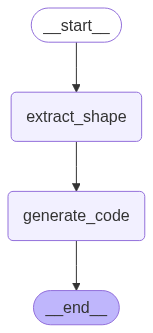

In [13]:
# LangGraph StateGraph 생성
geometry_agent = StateGraph(GeometryState)

# 노드 등록
geometry_agent.add_node("extract_shape", extract_shape_node)
geometry_agent.add_node("generate_code", generate_code_node)

# 엣지 연결
geometry_agent.set_entry_point("extract_shape")
geometry_agent.add_edge("extract_shape", "generate_code")
geometry_agent.add_edge("generate_code", END)

# 그래프 완성
app = geometry_agent.compile()
app

In [14]:
from IPython.display import SVG, display

def show_svg(svg_content):
    display(SVG(svg_content))

요청한 문장: 곧은선이 뭐야?
추출된 개념: 직선

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="25" font-size="25" text-anchor="middle">곧은선</text>
    <text x="250" y="75" font-size="25" text-anchor="middle">선분</text>
    <!-- 선분 -->
    <circle cx="125" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <circle cx="375" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="125" y1="125" x2="375" y2="125" stroke="black" stroke-width="2" />
    <!-- 반직선 -->
    <text x="250" y="175" font-size="25" text-anchor="middle">반직선</text>
    <circle cx="125" cy="250" r="1" stroke="black" stroke-width="2" fill="black" />
    <circle cx="375" cy="250" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="125" y1="250" x2="500" y2="250" stroke="black" stroke-width="2" />
    <!-- 직선 -->
    <text x="250" y="300" font-size="25" text-anchor="middle">직선</text>
    <circle cx="125" cy="375" r="1" stroke="black" stroke-wid

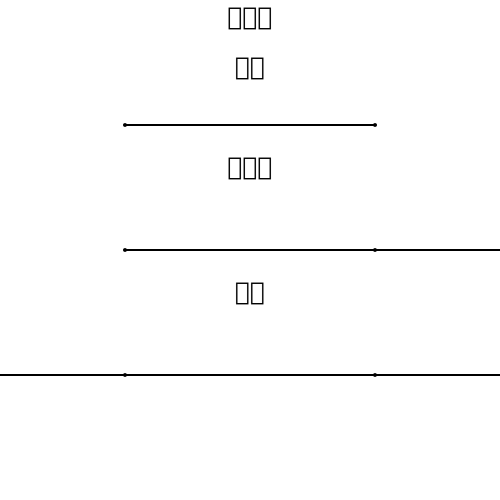

요청한 문장: 대표적인 굽은선을 그려줘
추출된 개념: 곡선

생성된 코드:
 
    <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">굽은선</text>
    <!-- 복잡한 S자 곡선 (두 개의 Cubic Bézier) -->
    <path d="M 100,400
    C 100,100 400,100 400,250
    C 400,400 100,400 100,100"
    stroke="black" fill="none" stroke-width="2"/>
    </svg>
    


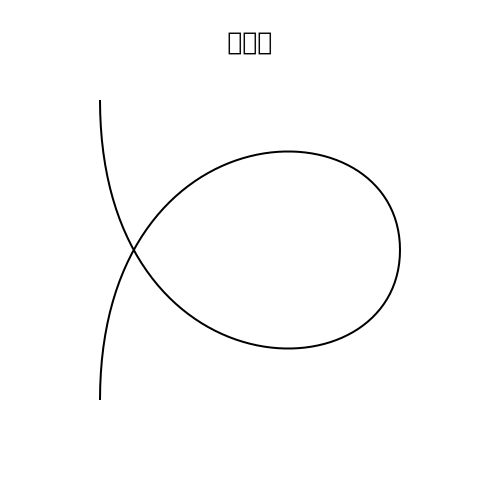

요청한 문장: 중심이 (0,0)이고 반지름이 2인 원을 그려주세요.
추출된 개념: Circle

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="166" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="1" stroke="black" stroke-width="2" fill="black" />
    </svg>
    


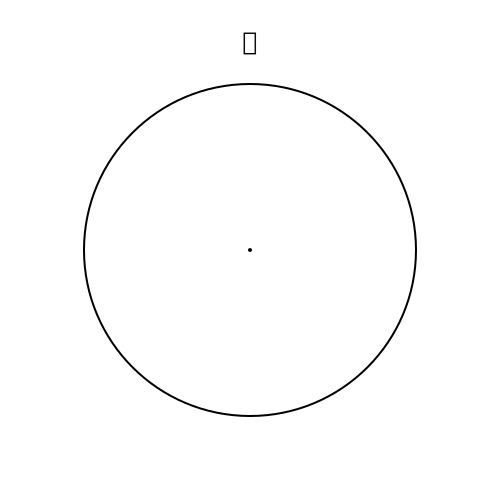

요청한 문장: 임의의 각도를 그려줘
추출된 개념: 각도

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
    <!-- 기준선 -->
    <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
    <!-- 기울어진 선 -->
    <line x1="125" y1="333" x2="250.00000000000003" y2="116.49364905389035" stroke="black" stroke-width="2" />
    <!-- 각도 호 -->
    <path d="M 150.0,289.69872981077805 A 50,50 0 0,1 175,333" stroke="black" stroke-width="2" fill="none"/>
    </svg>
    


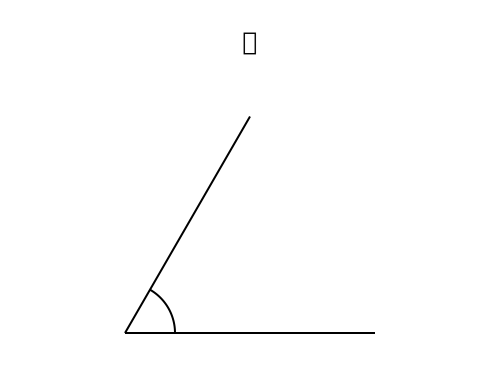

요청한 문장: 직각을 표현해줘
추출된 개념: 직각

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직각</text>
    <!-- 기준선 -->
    <line x1="125" y1="400" x2="458" y2="400" stroke="black" stroke-width="2" />
    <!-- 기울어진 선 -->
    <line x1="125" y1="400" x2="125" y2="67" stroke="black" stroke-width="2" />
    <!-- 직각 보조선 -->
    <line x1="175" y1="400" x2="175" y2="350" stroke="black" stroke-width="2" />
    <line x1="125" y1="350" x2="175" y2="350" stroke="black" stroke-width="2" />
    </svg>
    


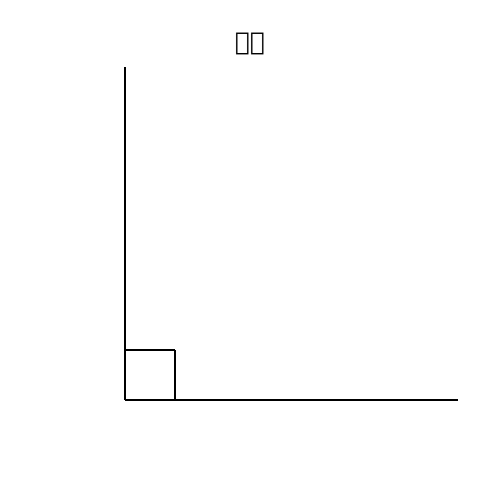

요청한 문장: 피타고라스 정리를 위해 직각삼각형 하나를 그려줘
추출된 개념: Right Triangle

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직각삼각형</text>
    <!-- 직각삼각형 -->
    <line x1="83" y1="416" x2="416" y2="416" stroke="black" stroke-width="2" />
    <line x1="416" y1="416" x2="416" y2="166" stroke="black" stroke-width="2" />
    <line x1="83" y1="416" x2="416" y2="166" stroke="black" stroke-width="2" />
    <!-- 직각 보조선 -->
    <line x1="366" y1="416" x2="366" y2="366" stroke="black" stroke-width="2" />
    <line x1="366" y1="366" x2="416" y2="366" stroke="black" stroke-width="2" />
    </svg>
    


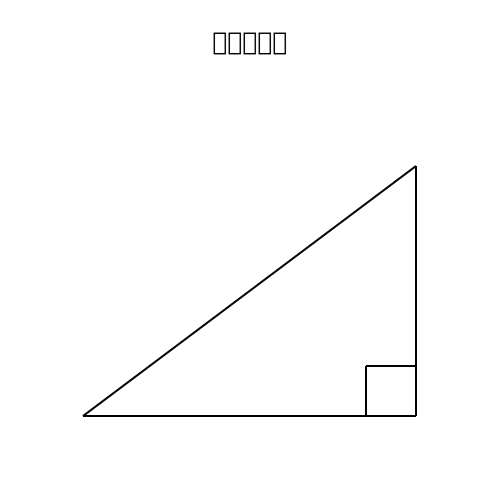

요청한 문장: 직사각형의 넓이
추출된 개념: Rectangle

생성된 코드:
 <svg width="500" height="350" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직사각형</text>
    <rect x="100" y="100" width="300" height="150" stroke="black" stroke-width="2" fill="none" />
    </svg>


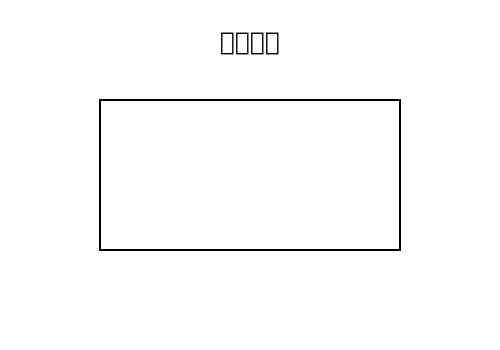

요청한 문장: 정사각형 하나를 그려줘
추출된 개념: Square

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">정사각형</text>
    <rect x="100" y="100" width="300" height="300" stroke="black" stroke-width="2" fill="none" />
    </svg>


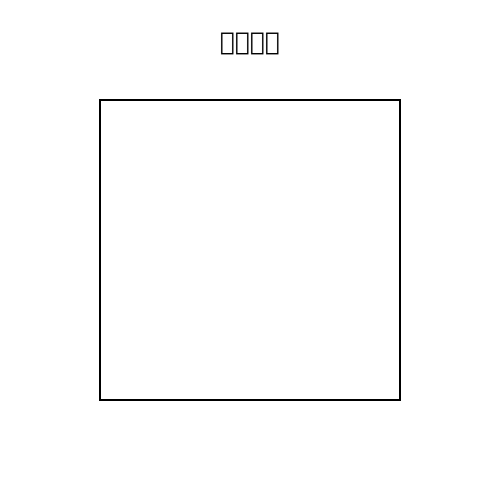

In [15]:
input_samples = [
    "곧은선이 뭐야?",
    "대표적인 굽은선을 그려줘",
    "중심이 (0,0)이고 반지름이 2인 원을 그려주세요.",
    "임의의 각도를 그려줘",
    "직각을 표현해줘",
    "피타고라스 정리를 위해 직각삼각형 하나를 그려줘",
    "직사각형의 넓이",
    "정사각형 하나를 그려줘",
]

# 그래프 호출
for i, user_input in enumerate(input_samples):
    result = app.invoke({"user_request": user_input})

    # 결과 출력
    print("요청한 문장:", result["user_request"])
    print("추출된 개념:", result["math_concept"])
    print("\n생성된 코드:\n", result["generated_code"])
    show_svg(result["generated_code"])
    print("=" * 100)